In [1]:
# Load dataset (student Portuguese scores)
import pandas as pd
d = pd.read_csv('student-por.csv',sep=',')
d.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


In [2]:
# generate binary label ( pass/fail ) based on G1+G2+G3 (test grades, each 0-20 pts); threshold for passing is sum >=30
d['pass'] = d.apply(lambda row: 1 if (row['G1']+row['G2']+row['G3']) >= 35 else 0,axis=1)
d=d.drop(['G1','G2','G3'],axis=1)
d.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,pass
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,no,no,4,3,4,1,1,3,4,0
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,yes,no,5,3,3,1,1,3,2,0
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,yes,no,4,3,2,2,3,3,6,1
3,GP,F,15,U,GT3,T,4,2,health,services,...,yes,yes,3,2,2,1,1,5,0,1
4,GP,F,16,U,GT3,T,3,3,other,other,...,no,no,4,3,2,1,2,5,0,1


In [3]:
# use one-hot encoding on categorical columns
d=pd.get_dummies(d,columns=['sex','school','address','famsize','Pstatus','Mjob','Fjob','reason','guardian','schoolsup','famsup','paid','activities','nursery','higher','internet','romantic'])
d.head()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
0,18,4,4,2,2,0,4,3,4,1,...,1,0,0,1,0,1,1,0,1,0
1,17,1,1,1,2,0,5,3,3,1,...,1,0,1,0,0,1,0,1,1,0
2,15,1,1,1,2,0,4,3,2,2,...,1,0,0,1,0,1,0,1,1,0
3,15,4,2,1,3,0,3,2,2,1,...,0,1,0,1,0,1,0,1,0,1
4,16,3,3,1,2,0,4,3,2,1,...,1,0,0,1,0,1,1,0,1,0


In [4]:
# shuffle rows
d = d.sample(frac=1)

# split training and testing data
d_train = d[:500]
d_test=d[500:]

d_train_att = d_train.drop(['pass'],axis=1)
d_train_pass = d_train['pass']

d_test_att = d_test.drop(['pass'],axis=1)
d_test_pass = d_test['pass']

d_att = d.drop(['pass'],axis=1)
d_pass = d['pass']

# number of passing students in whole dataset
import numpy as np 
print("Passing %d out of %d (%.2f%%)" % ( np.sum(d_pass), len(d_pass), 100*float(np.sum(d_pass))/len(d_pass) ) )

Passing 328 out of 649 (50.54%)


In [5]:
# fit a decision tree
from sklearn import tree
t = tree.DecisionTreeClassifier(criterion='entropy',max_depth=5)
t = t.fit(d_train_att,d_train_pass)


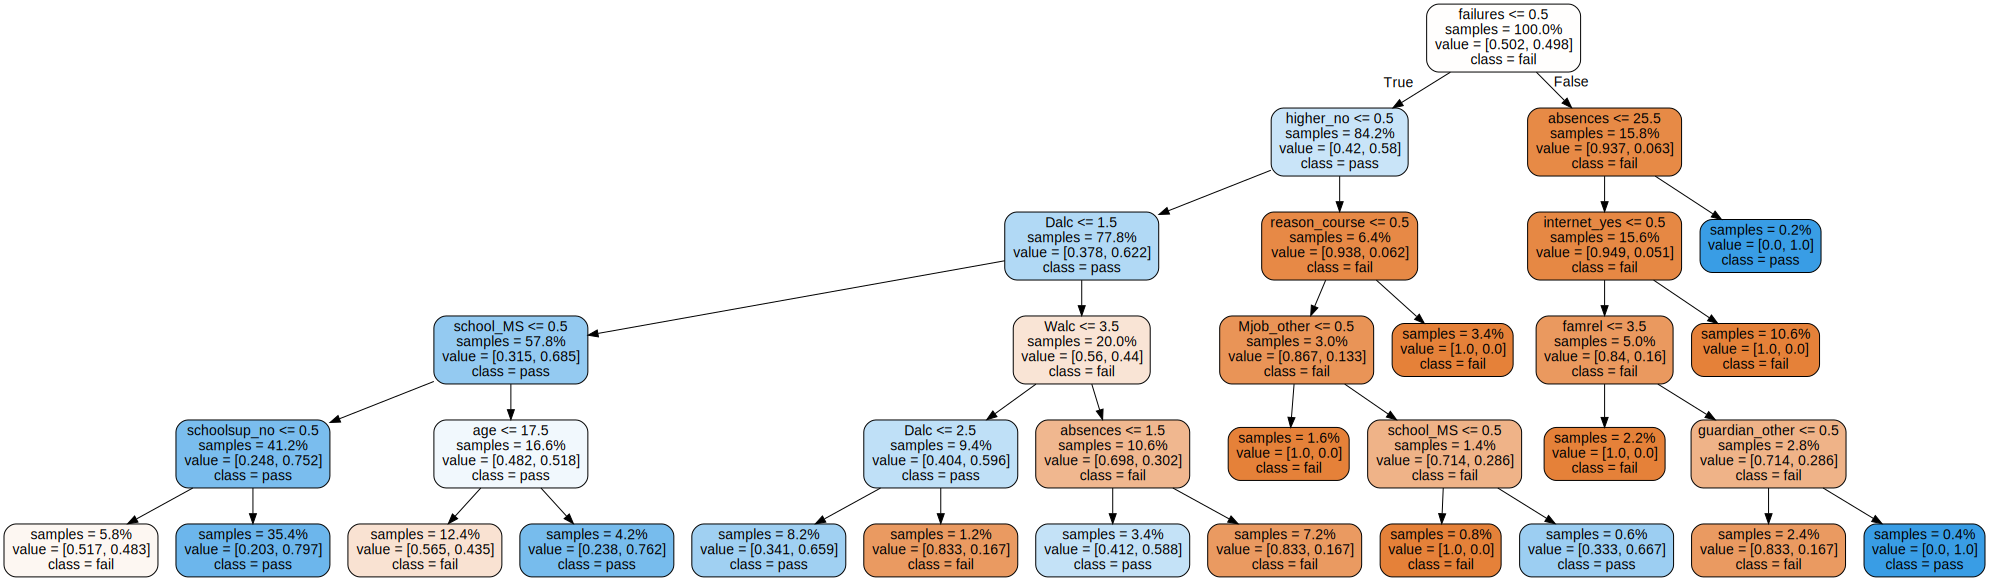

In [6]:
# visualize tree
import graphviz
dot_data = tree.export_graphviz(t, out_file = None, label = 'all', impurity = False, proportion=True,
                                feature_names = list(d_train_att), class_names = ['fail','pass'],
                                filled = True,rounded = True)
graph=graphviz.Source(dot_data)
graph

In [7]:
# save tree
tree.export_graphviz(t, out_file = 'student-performance.dot', label = 'all', impurity = False, proportion=True,
                                feature_names = list(d_train_att), class_names = ['fail','pass'],
                                filled = True,rounded = True)

In [8]:
t.score(d_test_att,d_test_pass)

0.6510067114093959

In [9]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(t,d_att,d_pass,cv=5)
# show average score and +/- two standard deviations away (covering 95% of scroes)
print('Accuracy: %0.2f ( +/- %0.2f)'%(scores.mean(),scores.std()*2))

Accuracy: 0.68 ( +/- 0.10)


In [10]:
#%%time
#from sklearn.model_selection import cross_val_score
#for max_depth in range(1,20):
#    t = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
#    scores = cross_val_score(t,d_att,d_pass,cv=5)
#    print('Max depth: %d, Accuracy: %0.2f ( +/- %0.2f)'%(max_depth,scores.mean(),scores.std()*2))

In [11]:
%%time
from sklearn.model_selection import cross_val_score
data = [[depth,score.mean(),score.std()*2]
        for score,depth in [
            (cross_val_score(t,d_att,d_pass,cv=5),t.max_depth)
            for t in [
                tree.DecisionTreeClassifier(criterion='entropy',max_depth=depth) 
                for depth in range(1,20)]]]
#data.sort(key=lambda d: d[1]-d[2],reverse=True )
for depth,mean,std in data[:5]:
    print('Max depth: %d, Accuracy: %0.2f ( +/- %0.2f)'%(depth,mean,std))

Max depth: 1, Accuracy: 0.64 ( +/- 0.03)
Max depth: 2, Accuracy: 0.69 ( +/- 0.07)
Max depth: 3, Accuracy: 0.66 ( +/- 0.05)
Max depth: 4, Accuracy: 0.69 ( +/- 0.06)
Max depth: 5, Accuracy: 0.68 ( +/- 0.09)
Wall time: 560 ms


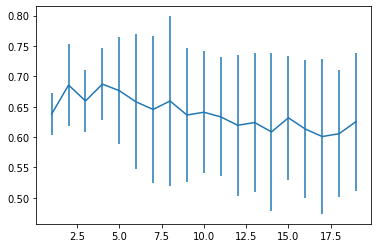

In [12]:
import matplotlib.pyplot as plt
fix,ax = plt.subplots()
data = np.array(data)
ax.errorbar(data[:,0],data[:,1],yerr=data[:,2])
plt.show()